# GoEmotions - Data Preparation Pipeline

**Task**: Multi-label Emotion Classification  
**Dataset**: [GoEmotions](https://huggingface.co/datasets/google-research-datasets/go_emotions)  
**Classes**: 27 emotion categories + neutral  

---

## Pipeline Overview

1. Environment Setup & Dependencies
2. Dataset Loading & Exploration
3. Multi-label Data Analysis
4. Label Distribution & Co-occurrence
5. Text Preprocessing
6. Multi-hot Encoding
7. Tokenization Strategy
8. Save Processed Data

## 1. Environment Setup

In [1]:
!pip install -q transformers datasets accelerate evaluate scikit-learn
!pip install -q matplotlib seaborn pandas numpy

In [2]:
import os
import json
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from collections import Counter
from itertools import combinations

from datasets import load_dataset, DatasetDict, Dataset
from transformers import AutoTokenizer

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("✅ All imports successful!")

✅ All imports successful!


In [3]:
class Config:
    DATASET_NAME = "google-research-datasets/go_emotions"
    DATASET_CONFIG = "simplified"
    
    MODEL_CHECKPOINTS = {
        'bert-base': 'bert-base-uncased',
        'distilbert': 'distilbert-base-uncased',
        'tinybert': 'huawei-noah/TinyBERT_General_4L_312D'
    }
    
    DEFAULT_TOKENIZER = 'bert-base-uncased'
    
    MAX_LENGTH = 64
    PADDING = 'max_length'
    TRUNCATION = True
    
    LABEL_NAMES = [
        'admiration', 'amusement', 'anger', 'annoyance', 'approval',
        'caring', 'confusion', 'curiosity', 'desire', 'disappointment',
        'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
        'gratitude', 'grief', 'joy', 'love', 'nervousness',
        'optimism', 'pride', 'realization', 'relief', 'remorse',
        'sadness', 'surprise', 'neutral'
    ]
    NUM_LABELS = 28
    
    DATA_DIR = './processed_data'
    
    SEED = 42

config = Config()

os.makedirs(config.DATA_DIR, exist_ok=True)

print("📋 Configuration loaded!")
print(f"   Dataset: {config.DATASET_NAME}")
print(f"   Config: {config.DATASET_CONFIG}")
print(f"   Max Length: {config.MAX_LENGTH}")
print(f"   Number of Labels: {config.NUM_LABELS}")

📋 Configuration loaded!
   Dataset: google-research-datasets/go_emotions
   Config: simplified
   Max Length: 64
   Number of Labels: 28


## 2. Dataset Loading & Exploration

In [4]:
print("📥 Loading GoEmotions dataset...")
raw_dataset = load_dataset(config.DATASET_NAME, config.DATASET_CONFIG)

print("\n✅ Dataset loaded successfully!")
print(raw_dataset)

📥 Loading GoEmotions dataset...


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]


✅ Dataset loaded successfully!
DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})


In [5]:
print("📊 Dataset Structure:")
print("="*50)

for split_name, split_data in raw_dataset.items():
    print(f"\n{split_name.upper()}:")
    print(f"  Samples: {len(split_data):,}")
    print(f"  Features: {split_data.features}")

📊 Dataset Structure:

TRAIN:
  Samples: 43,410
  Features: {'text': Value('string'), 'labels': List(ClassLabel(names=['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'])), 'id': Value('string')}

VALIDATION:
  Samples: 5,426
  Features: {'text': Value('string'), 'labels': List(ClassLabel(names=['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'])), 'id': Value('string')}

TEST:
  Samples: 5,427
  Features: {'text': Value('string'), '

In [6]:
print("📝 Sample Data Points:")
print("="*80)

for i in range(5):
    sample = raw_dataset['train'][i]
    print(f"\n--- Sample {i+1} ---")
    print(f"Text: {sample['text']}")
    print(f"Label indices: {sample['labels']}")
    label_names = [config.LABEL_NAMES[idx] for idx in sample['labels']]
    print(f"Label names: {label_names}")

📝 Sample Data Points:

--- Sample 1 ---
Text: My favourite food is anything I didn't have to cook myself.
Label indices: [27]
Label names: ['neutral']

--- Sample 2 ---
Text: Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
Label indices: [27]
Label names: ['neutral']

--- Sample 3 ---
Text: WHY THE FUCK IS BAYLESS ISOING
Label indices: [2]
Label names: ['anger']

--- Sample 4 ---
Text: To make her feel threatened
Label indices: [14]
Label names: ['fear']

--- Sample 5 ---
Text: Dirty Southern Wankers
Label indices: [3]
Label names: ['annoyance']


In [7]:
def dataset_to_dataframe(dataset):
    """Convert HuggingFace dataset to DataFrame with expanded labels."""
    df = pd.DataFrame(dataset)
    df['num_labels'] = df['labels'].apply(len)
    return df

df_train = dataset_to_dataframe(raw_dataset['train'])
df_val = dataset_to_dataframe(raw_dataset['validation'])
df_test = dataset_to_dataframe(raw_dataset['test'])

print("DataFrame shapes:")
print(f"  Train: {df_train.shape}")
print(f"  Validation: {df_val.shape}")
print(f"  Test: {df_test.shape}")

df_train.head()

DataFrame shapes:
  Train: (43410, 4)
  Validation: (5426, 4)
  Test: (5427, 4)


,text,labels,id,num_labels
0,My favourite food is anything I didn't have to...,[27],eebbqej,1
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,1
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,1
3,To make her feel threatened,[14],ed7ypvh,1
4,Dirty Southern Wankers,[3],ed0bdzj,1


## 3. Multi-label Data Analysis

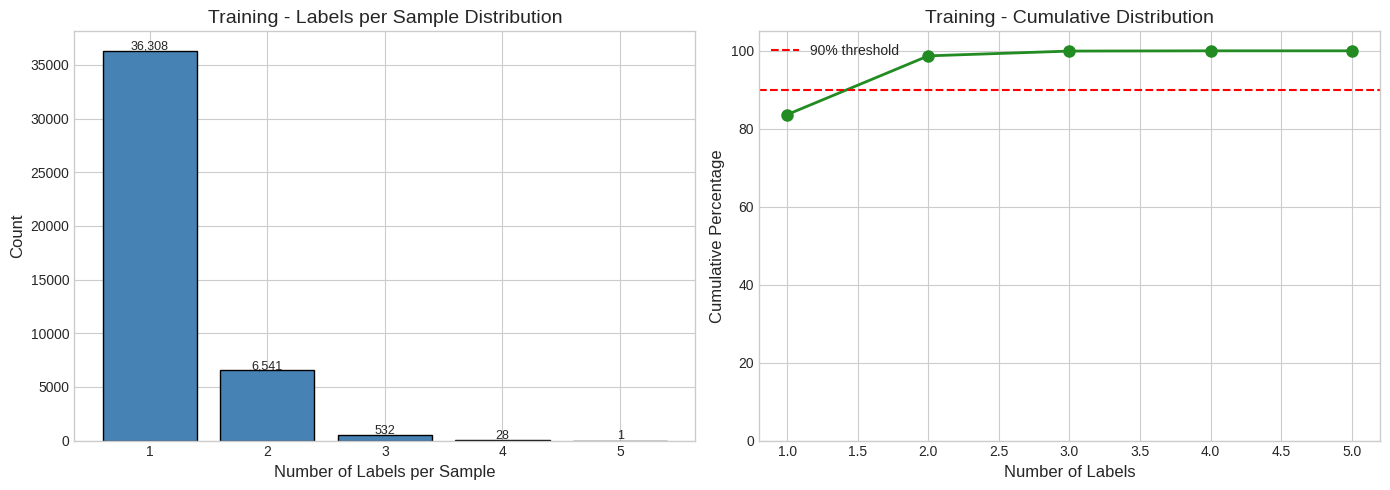


📊 Training Label Count Statistics:
   Min labels: 1
   Max labels: 5
   Mean labels: 1.18
   Median labels: 1.0
   Single-label samples: 36,308 (83.6%)
   Multi-label samples: 7,102 (16.4%)


In [8]:
def analyze_label_counts(df, split_name):
    """Analyze distribution of label counts per sample."""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    label_counts = df['num_labels'].value_counts().sort_index()
    
    axes[0].bar(label_counts.index, label_counts.values, color='steelblue', edgecolor='black')
    axes[0].set_xlabel('Number of Labels per Sample', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].set_title(f'{split_name} - Labels per Sample Distribution', fontsize=14)
    
    for x, y in zip(label_counts.index, label_counts.values):
        axes[0].text(x, y + 100, f'{y:,}', ha='center', fontsize=9)
    
    cumulative = label_counts.cumsum() / len(df) * 100
    axes[1].plot(cumulative.index, cumulative.values, 'o-', color='forestgreen', linewidth=2, markersize=8)
    axes[1].axhline(y=90, color='red', linestyle='--', label='90% threshold')
    axes[1].set_xlabel('Number of Labels', fontsize=12)
    axes[1].set_ylabel('Cumulative Percentage', fontsize=12)
    axes[1].set_title(f'{split_name} - Cumulative Distribution', fontsize=14)
    axes[1].legend()
    axes[1].set_ylim(0, 105)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 {split_name} Label Count Statistics:")
    print(f"   Min labels: {df['num_labels'].min()}")
    print(f"   Max labels: {df['num_labels'].max()}")
    print(f"   Mean labels: {df['num_labels'].mean():.2f}")
    print(f"   Median labels: {df['num_labels'].median():.1f}")
    print(f"   Single-label samples: {(df['num_labels'] == 1).sum():,} ({(df['num_labels'] == 1).mean()*100:.1f}%)")
    print(f"   Multi-label samples: {(df['num_labels'] > 1).sum():,} ({(df['num_labels'] > 1).mean()*100:.1f}%)")

analyze_label_counts(df_train, 'Training')

## 4. Label Distribution & Co-occurrence

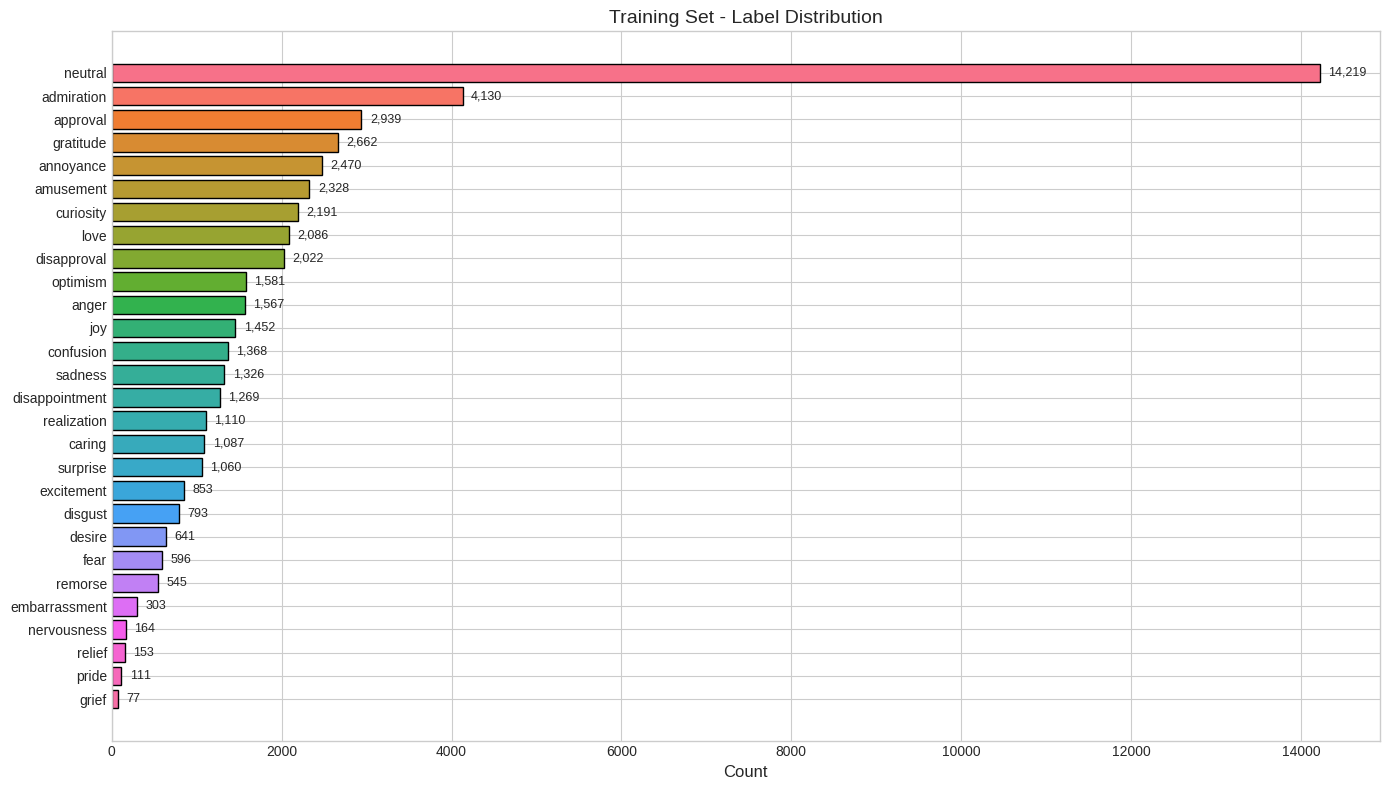


📊 Top 10 Most Common Labels:
 label_idx  label_name  count
        27     neutral  14219
         0  admiration   4130
         4    approval   2939
        15   gratitude   2662
         3   annoyance   2470
         1   amusement   2328
         7   curiosity   2191
        18        love   2086
        10 disapproval   2022
        20    optimism   1581

📊 Top 10 Least Common Labels:
 label_idx    label_name  count
        13    excitement    853
        11       disgust    793
         8        desire    641
        14          fear    596
        24       remorse    545
        12 embarrassment    303
        19   nervousness    164
        23        relief    153
        21         pride    111
        16         grief     77


In [9]:
def get_label_distribution(df, label_names):
    """Get distribution of each label."""
    label_counts = Counter()
    for labels in df['labels']:
        for label in labels:
            label_counts[label] += 1
    
    return pd.DataFrame([
        {'label_idx': idx, 'label_name': label_names[idx], 'count': label_counts[idx]}
        for idx in range(len(label_names))
    ]).sort_values('count', ascending=False)

label_dist = get_label_distribution(df_train, config.LABEL_NAMES)

fig, ax = plt.subplots(figsize=(14, 8))

colors = sns.color_palette('husl', len(label_dist))
bars = ax.barh(range(len(label_dist)), label_dist['count'].values, color=colors, edgecolor='black')
ax.set_yticks(range(len(label_dist)))
ax.set_yticklabels(label_dist['label_name'].values)
ax.set_xlabel('Count', fontsize=12)
ax.set_title('Training Set - Label Distribution', fontsize=14)
ax.invert_yaxis()

for bar, count in zip(bars, label_dist['count'].values):
    ax.text(bar.get_width() + 100, bar.get_y() + bar.get_height()/2,
           f'{count:,}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(config.DATA_DIR, 'go_emotions_label_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Top 10 Most Common Labels:")
print(label_dist.head(10).to_string(index=False))

print("\n📊 Top 10 Least Common Labels:")
print(label_dist.tail(10).to_string(index=False))

In [10]:
print("\n⚖️ Class Imbalance Analysis:")
print("="*50)

max_count = label_dist['count'].max()
min_count = label_dist['count'].min()
imbalance_ratio = max_count / min_count

print(f"   Most common: {label_dist.iloc[0]['label_name']} ({max_count:,})")
print(f"   Least common: {label_dist.iloc[-1]['label_name']} ({min_count:,})")
print(f"   Imbalance ratio: {imbalance_ratio:.1f}x")

rare_threshold = len(df_train) * 0.01
rare_labels = label_dist[label_dist['count'] < rare_threshold]
print(f"\n   Rare labels (< 1% of samples): {len(rare_labels)}")
for _, row in rare_labels.iterrows():
    print(f"      - {row['label_name']}: {row['count']:,} ({row['count']/len(df_train)*100:.2f}%)")


⚖️ Class Imbalance Analysis:
   Most common: neutral (14,219)
   Least common: grief (77)
   Imbalance ratio: 184.7x

   Rare labels (< 1% of samples): 5
      - embarrassment: 303 (0.70%)
      - nervousness: 164 (0.38%)
      - relief: 153 (0.35%)
      - pride: 111 (0.26%)
      - grief: 77 (0.18%)


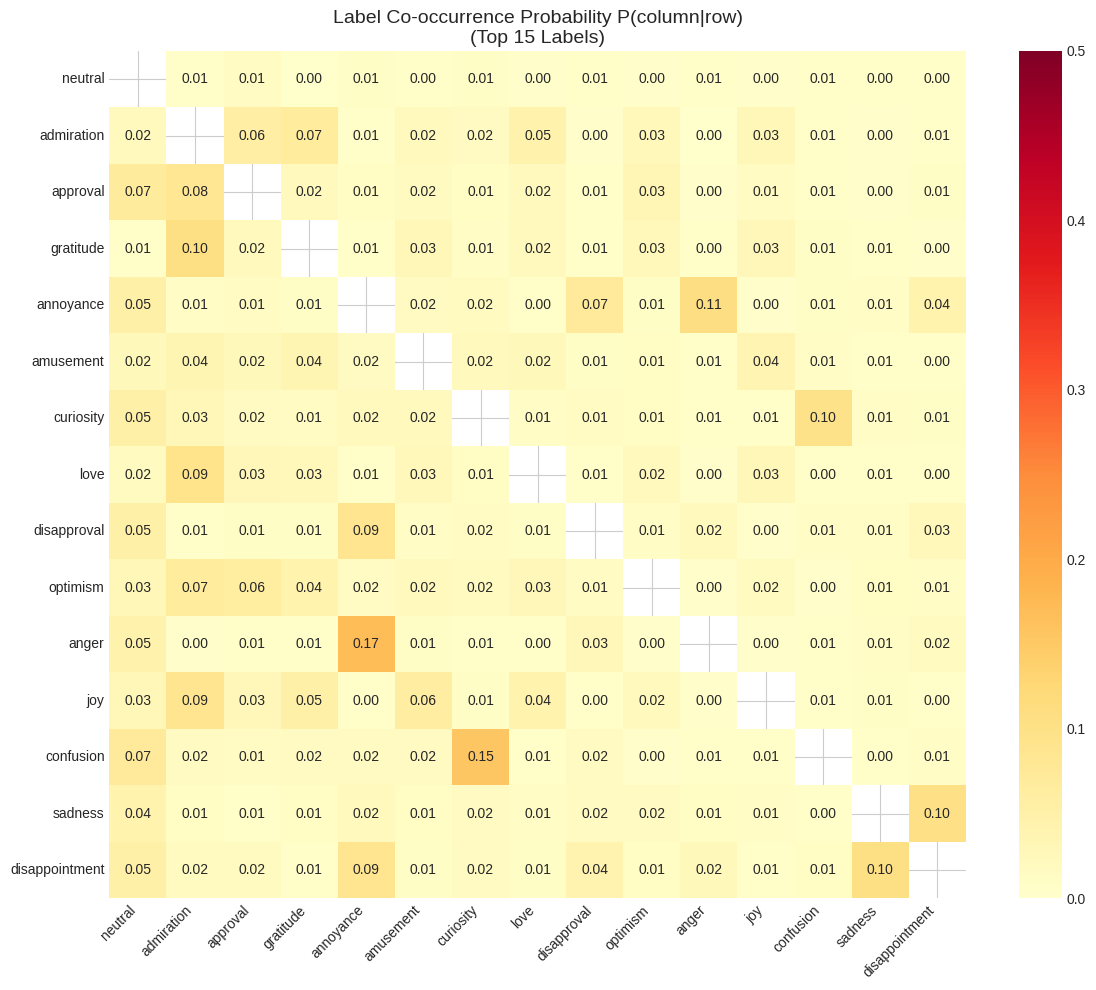

In [11]:
def compute_cooccurrence_matrix(df, num_labels):
    """Compute label co-occurrence matrix."""
    cooccurrence = np.zeros((num_labels, num_labels))
    
    for labels in df['labels']:
        for i, j in combinations(labels, 2):
            cooccurrence[i, j] += 1
            cooccurrence[j, i] += 1
        for label in labels:
            cooccurrence[label, label] += 1
    
    return cooccurrence

cooccurrence_matrix = compute_cooccurrence_matrix(df_train, config.NUM_LABELS)

with np.errstate(divide='ignore', invalid='ignore'):
    conditional_prob = cooccurrence_matrix / cooccurrence_matrix.diagonal()[:, np.newaxis]
    conditional_prob = np.nan_to_num(conditional_prob)

top_labels_idx = label_dist.head(15)['label_idx'].values
top_labels_names = label_dist.head(15)['label_name'].values

fig, ax = plt.subplots(figsize=(12, 10))

subset_matrix = conditional_prob[np.ix_(top_labels_idx, top_labels_idx)]

mask = np.eye(len(top_labels_idx), dtype=bool)

sns.heatmap(
    subset_matrix,
    annot=True,
    fmt='.2f',
    cmap='YlOrRd',
    xticklabels=top_labels_names,
    yticklabels=top_labels_names,
    ax=ax,
    mask=mask,
    vmin=0,
    vmax=0.5
)

ax.set_title('Label Co-occurrence Probability P(column|row)\n(Top 15 Labels)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(config.DATA_DIR, 'go_emotions_cooccurrence.png'), dpi=150, bbox_inches='tight')
plt.show()

In [12]:
def get_top_label_pairs(df, label_names, top_k=15):
    """Get most common label pair co-occurrences."""
    pair_counts = Counter()
    
    for labels in df['labels']:
        if len(labels) >= 2:
            for pair in combinations(sorted(labels), 2):
                pair_counts[pair] += 1
    
    top_pairs = []
    for (i, j), count in pair_counts.most_common(top_k):
        top_pairs.append({
            'label_1': label_names[i],
            'label_2': label_names[j],
            'count': count
        })
    
    return pd.DataFrame(top_pairs)

top_pairs = get_top_label_pairs(df_train, config.LABEL_NAMES)
print("\n🔗 Top 15 Label Pair Co-occurrences:")
print(top_pairs.to_string(index=False))


🔗 Top 15 Label Pair Co-occurrences:
       label_1        label_2  count
    admiration      gratitude    279
         anger      annoyance    269
    admiration       approval    246
     confusion      curiosity    212
      approval        neutral    202
    admiration           love    192
     annoyance    disapproval    178
disappointment        sadness    133
     annoyance        neutral    132
    admiration            joy    126
     curiosity        neutral    118
     annoyance disappointment    110
   disapproval        neutral    109
    admiration       optimism    106
      approval       optimism    100


## 5. Text Analysis

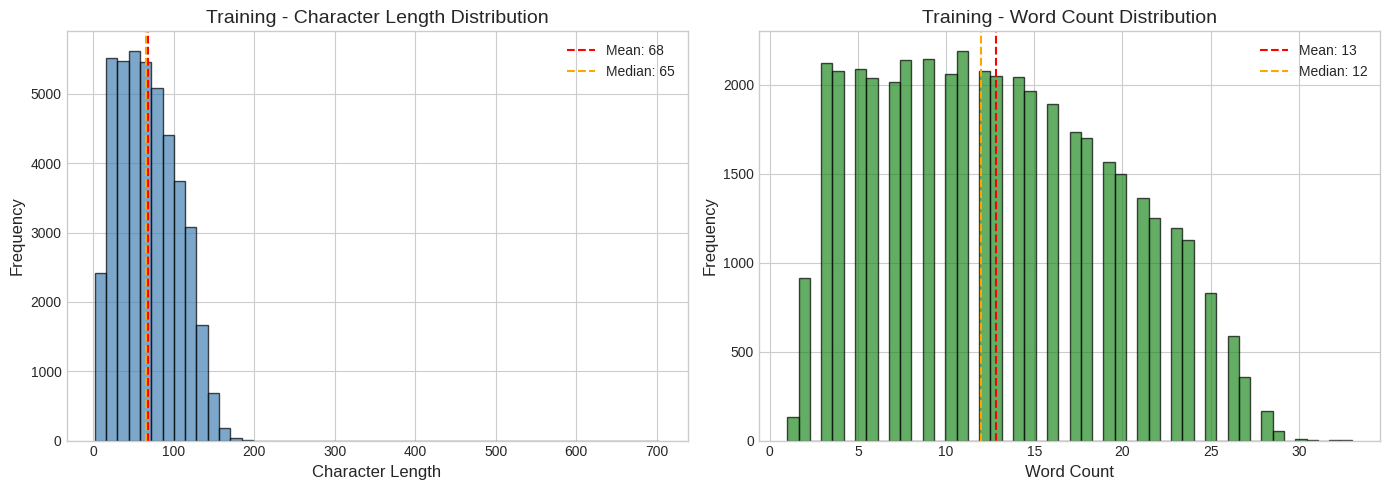


📏 Text Length Statistics:
   Character Length - Min: 2, Max: 703, Mean: 68.4
   Word Count - Min: 1, Max: 33, Mean: 12.8


In [13]:
df_train['text_length'] = df_train['text'].str.len()
df_train['word_count'] = df_train['text'].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_train['text_length'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df_train['text_length'].mean(), color='red', linestyle='--', label=f"Mean: {df_train['text_length'].mean():.0f}")
axes[0].axvline(df_train['text_length'].median(), color='orange', linestyle='--', label=f"Median: {df_train['text_length'].median():.0f}")
axes[0].set_xlabel('Character Length', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Training - Character Length Distribution', fontsize=14)
axes[0].legend()

axes[1].hist(df_train['word_count'], bins=50, color='forestgreen', edgecolor='black', alpha=0.7)
axes[1].axvline(df_train['word_count'].mean(), color='red', linestyle='--', label=f"Mean: {df_train['word_count'].mean():.0f}")
axes[1].axvline(df_train['word_count'].median(), color='orange', linestyle='--', label=f"Median: {df_train['word_count'].median():.0f}")
axes[1].set_xlabel('Word Count', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Training - Word Count Distribution', fontsize=14)
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n📏 Text Length Statistics:")
print(f"   Character Length - Min: {df_train['text_length'].min()}, Max: {df_train['text_length'].max()}, Mean: {df_train['text_length'].mean():.1f}")
print(f"   Word Count - Min: {df_train['word_count'].min()}, Max: {df_train['word_count'].max()}, Mean: {df_train['word_count'].mean():.1f}")

## 6. Multi-hot Encoding

In [14]:
import re

def preprocess_text(text):
    """
    Minimal text preprocessing for Reddit comments.
    """
    if not isinstance(text, str):
        return ""
    
    text = ' '.join(text.split())
    
    text = re.sub(r'\[deleted\]', '', text)
    text = re.sub(r'\[removed\]', '', text)
    
    return text.strip()

def convert_labels_to_multihot(labels, num_labels):
    """
    Convert list of label indices to multi-hot encoding.
    """
    multihot = [0.0] * num_labels
    for label in labels:
        multihot[label] = 1.0
    return multihot

def preprocess_example(example):
    """Preprocess a single example."""
    example['text'] = preprocess_text(example['text'])
    example['labels_multihot'] = convert_labels_to_multihot(example['labels'], config.NUM_LABELS)
    return example

sample = raw_dataset['train'][0]
processed = preprocess_example(sample.copy())
print("Sample preprocessing:")
print(f"  Original labels: {sample['labels']}")
print(f"  Multi-hot labels: {processed['labels_multihot']}")
print(f"  Active labels: {[config.LABEL_NAMES[i] for i, v in enumerate(processed['labels_multihot']) if v == 1.0]}")

Sample preprocessing:
  Original labels: [27]
  Multi-hot labels: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
  Active labels: ['neutral']


In [15]:
print("🔄 Preprocessing dataset...")

processed_dataset = raw_dataset.map(
    preprocess_example,
    desc="Preprocessing"
)

print("✅ Preprocessing complete!")
print(f"\nNew features: {processed_dataset['train'].features}")

🔄 Preprocessing dataset...


Preprocessing:   0%|          | 0/43410 [00:00<?, ? examples/s]

Preprocessing:   0%|          | 0/5426 [00:00<?, ? examples/s]

Preprocessing:   0%|          | 0/5427 [00:00<?, ? examples/s]

✅ Preprocessing complete!

New features: {'text': Value('string'), 'labels': List(ClassLabel(names=['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'])), 'id': Value('string'), 'labels_multihot': List(Value('float64'))}


## 7. Tokenization Strategy

In [16]:
print(f"📦 Loading tokenizer: {config.DEFAULT_TOKENIZER}")
tokenizer = AutoTokenizer.from_pretrained(config.DEFAULT_TOKENIZER)

print(f"\n✅ Tokenizer loaded!")
print(f"   Vocabulary size: {tokenizer.vocab_size:,}")

📦 Loading tokenizer: bert-base-uncased

✅ Tokenizer loaded!
   Vocabulary size: 30,522


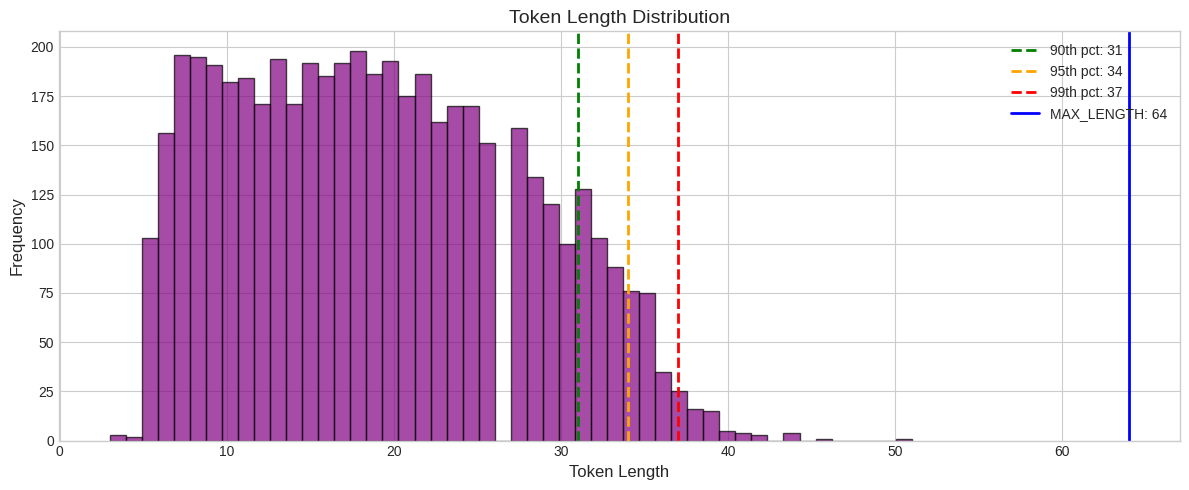


✅ Coverage with MAX_LENGTH=64: 100.0%


In [17]:
def analyze_tokenization_length(dataset, tokenizer, sample_size=5000):
    """
    Analyze token length distribution.
    """
    texts = dataset['train']['text'][:sample_size]
    
    token_lengths = []
    for text in texts:
        tokens = tokenizer(text, add_special_tokens=True)
        token_lengths.append(len(tokens['input_ids']))
    
    token_lengths = np.array(token_lengths)
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    ax.hist(token_lengths, bins=50, color='purple', edgecolor='black', alpha=0.7)
    
    percentiles = [90, 95, 99]
    colors = ['green', 'orange', 'red']
    for pct, color in zip(percentiles, colors):
        val = np.percentile(token_lengths, pct)
        ax.axvline(val, color=color, linestyle='--', linewidth=2, label=f'{pct}th pct: {val:.0f}')
    
    ax.axvline(config.MAX_LENGTH, color='blue', linestyle='-', linewidth=2, label=f'MAX_LENGTH: {config.MAX_LENGTH}')
    
    ax.set_xlabel('Token Length', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Token Length Distribution', fontsize=14)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    coverage = (token_lengths <= config.MAX_LENGTH).mean() * 100
    print(f"\n✅ Coverage with MAX_LENGTH={config.MAX_LENGTH}: {coverage:.1f}%")
    
    return token_lengths

token_lengths = analyze_tokenization_length(processed_dataset, tokenizer)

In [18]:
def tokenize_function(examples):
    """
    Tokenize batch and prepare for multi-label classification.
    """
    tokenized = tokenizer(
        examples['text'],
        max_length=config.MAX_LENGTH,
        padding=config.PADDING,
        truncation=config.TRUNCATION
    )
    
    tokenized['labels'] = examples['labels_multihot']
    
    return tokenized

print("🔄 Tokenizing dataset...")
tokenized_dataset = processed_dataset.map(
    tokenize_function,
    batched=True,
    desc="Tokenizing",
    remove_columns=['text', 'labels_multihot']
)

tokenized_dataset = tokenized_dataset.rename_column('labels', 'labels_float')

print("\n✅ Tokenization complete!")
print(tokenized_dataset)

🔄 Tokenizing dataset...


Tokenizing:   0%|          | 0/43410 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/5426 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/5427 [00:00<?, ? examples/s]


✅ Tokenization complete!
DatasetDict({
    train: Dataset({
        features: ['labels_float', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['labels_float', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['labels_float', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5427
    })
})


In [19]:
print("🔍 Tokenization Verification:")
print("="*50)

sample = tokenized_dataset['train'][0]
print(f"\nSample features: {list(sample.keys())}")
print(f"input_ids length: {len(sample['input_ids'])}")
print(f"attention_mask length: {len(sample['attention_mask'])}")
print(f"labels_float shape: {len(sample['labels_float'])}")
print(f"Active labels: {[config.LABEL_NAMES[i] for i, v in enumerate(sample['labels_float']) if v == 1.0]}")

🔍 Tokenization Verification:

Sample features: ['labels_float', 'id', 'input_ids', 'token_type_ids', 'attention_mask']
input_ids length: 64
attention_mask length: 64
labels_float shape: 28
Active labels: ['neutral']


## 8. Save Processed Data

In [20]:
final_dataset = tokenized_dataset.rename_column('labels_float', 'labels')

final_dataset.set_format('torch')

print("✅ Dataset prepared for training")
print(final_dataset)

✅ Dataset prepared for training
DatasetDict({
    train: Dataset({
        features: ['labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5427
    })
})


In [21]:
print("💾 Saving processed dataset...")

save_path = os.path.join(config.DATA_DIR, 'go_emotions_tokenized')
final_dataset.save_to_disk(save_path)

print(f"✅ Dataset saved to: {save_path}")

💾 Saving processed dataset...


Saving the dataset (0/1 shards):   0%|          | 0/43410 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5427 [00:00<?, ? examples/s]

✅ Dataset saved to: ./processed_data/go_emotions_tokenized


In [22]:
config_dict = {
    'dataset_name': config.DATASET_NAME,
    'dataset_config': config.DATASET_CONFIG,
    'max_length': config.MAX_LENGTH,
    'padding': config.PADDING,
    'truncation': config.TRUNCATION,
    'label_names': config.LABEL_NAMES,
    'num_labels': config.NUM_LABELS,
    'model_checkpoints': config.MODEL_CHECKPOINTS,
    'default_tokenizer': config.DEFAULT_TOKENIZER,
    'seed': config.SEED,
    'train_size': len(final_dataset['train']),
    'val_size': len(final_dataset['validation']),
    'test_size': len(final_dataset['test']),
    'task_type': 'multi_label_classification',
    'label_distribution': label_dist[['label_name', 'count']].to_dict('records')
}

config_path = os.path.join(config.DATA_DIR, 'go_emotions_config.json')
with open(config_path, 'w') as f:
    json.dump(config_dict, f, indent=2)

print(f"✅ Configuration saved to: {config_path}")

✅ Configuration saved to: ./processed_data/go_emotions_config.json


In [23]:
print("🔍 Verifying saved data...")

from datasets import load_from_disk

loaded_dataset = load_from_disk(save_path)
print(f"\n✅ Dataset loaded successfully!")
print(loaded_dataset)

🔍 Verifying saved data...

✅ Dataset loaded successfully!
DatasetDict({
    train: Dataset({
        features: ['labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5427
    })
})
